In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\JOSHWIN ISAC\AppData\Local\Temp\ipykernel_26932\3029127538.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [5]:
import os
import cv2
test_path="D:\\dataset for lab programs\\data\\test"
classes= sorted(os.listdir(test_path))

# Count the number of classes
num_classes = len(classes)

# Print the class names and the total number of classes
print("Class Names: \n", classes)
print("Number of Classes:", num_classes)

Class Names: 
 ['benign', 'malignant']
Number of Classes: 2


In [6]:
import os
import cv2
train_path="D:\\dataset for lab programs\\data\\train"
classes= sorted(os.listdir(test_path))

# Count the number of classes
num_classes = len(classes)

# Print the class names and the total number of classes
print("Class Names: \n", classes)
print("Number of Classes:", num_classes)

Class Names: 
 ['benign', 'malignant']
Number of Classes: 2


In [7]:
img_width, img_height = 224, 224

In [8]:
def load_images(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith(".jpg"):
                img = cv2.imread(os.path.join(label_dir, filename))
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                if label == 'benign':
                    labels.append(0)
                else:
                    labels.append(1)
    return images, labels

train_images, train_labels = load_images(train_path)
test_images, test_labels = load_images(test_path)

In [9]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [10]:
#normalizing thr\e pixels

train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
# Data augmentation for training data
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented training data
train_data_generator.fit(train_images)


In [27]:
# Data augmentation for training data
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented training data
train_data_generator.fit(test_images)


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [14]:
# Define a learning rate scheduler
initial_learning_rate = 0.01

def lr_schedule(epoch, lr):
    if epoch < 10:
        return initial_learning_rate
    else:
        return initial_learning_rate * tf.math.exp(0.1 * (10 - epoch))

lr_scheduler = LearningRateScheduler(lr_schedule)

# Define an Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [15]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable=False

model_vgg16=Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256,activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))

In [16]:
model_vgg16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
# Replace 'train' with the provided full train path
train_generator = train_data_generator.flow_from_directory('D:\\dataset for lab programs\\data\\train', target_size=(224, 224), batch_size=32, class_mode='binary')
# Fit the model with the training data generator and callbacks
history = model_vgg16.fit(train_generator, epochs=10, callbacks=[lr_scheduler, early_stopping],loss='binary_crossentropy',metrics=['accuracy'])


Found 2637 images belonging to 2 classes.
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.7597 - loss: 1.0726 - learning_rate: 0.0100
Epoch 2/10


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.7842 - loss: 0.4803 - learning_rate: 0.0100
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.7941 - loss: 0.4296 - learning_rate: 0.0100
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.7511 - loss: 0.4835 - learning_rate: 0.0100
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 555s 7s/step - accuracy: 0.7672 - loss: 0.4548 - learning_rate: 0.0100
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.7709 - loss: 0.4409 - learning_rate: 0.0100
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7738 - loss: 0.4198 - learning_rate: 0.0100
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.7078 - loss: 0.4758 - learning_rate: 0.0100
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.7527 - loss: 0.4906 - learning_rate: 0.0100
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7548 - loss: 0.4579 - learning_rate: 0.0100


In [25]:
vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(test_images, test_labels)
print("VGG16 Test Accuracy:", vgg16_accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8364 - loss: 0.3166
VGG16 Test Accuracy: 0.8272727131843567


In [ ]:
test_generator=test_data_generator.flow_from_directory('D:\\dataset for lab programs\\data\\test', target_size=(224, 224), batch_size=32, class_mode='binary')
# Fit the model with the training data generator and callbacks
history = model_vgg16.fit(test_generator, epochs=10, callbacks=[lr_scheduler, early_stopping])





In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score,f1_score

vgg16_predictions = model_vgg16.predict(test_images)
vgg16_predictions = (vgg16_predictions > 0.5).astype(int)

print("Classification Report for VGG16:")
print(classification_report(test_labels, vgg16_predictions))

21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       360
           1       0.78      0.83      0.80       300

    accuracy                           0.82       660
   macro avg       0.81      0.82      0.81       660
weighted avg       0.82      0.82      0.82       660



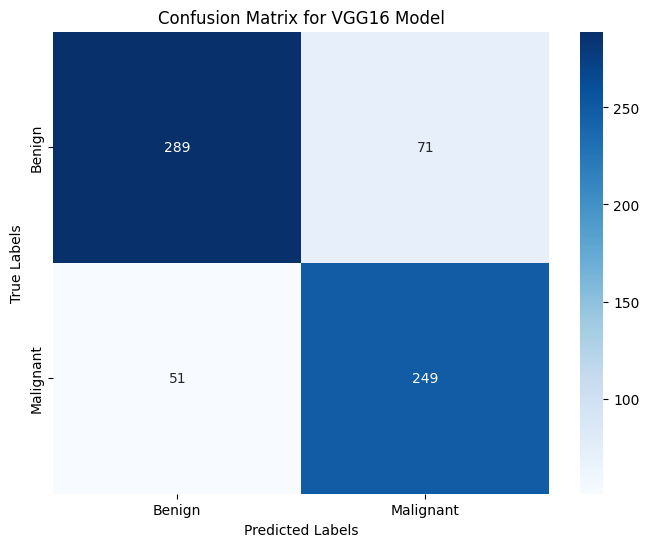

In [34]:
import seaborn as sn
# Calculate the confusion matrix

cm = confusion_matrix(test_labels, vgg16_predictions)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


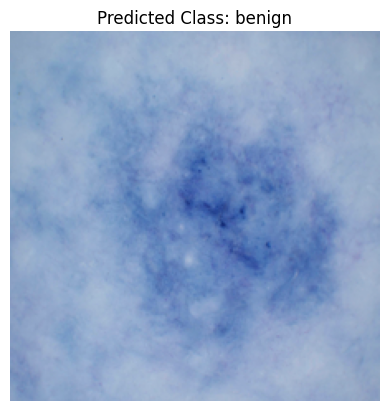

In [70]:
import cv2
import random
# Get a random image path from the test dataset
test_path = "D:\\dataset for lab programs\\data\\test"
random_folder = random.choice(os.listdir(test_path))
random_image_path = os.path.join(test_path, random_folder, random.choice(os.listdir(os.path.join(test_path, random_folder))))

# Read and preprocess the randomly selected image
img = cv2.imread(random_image_path)
img = cv2.resize(img, (224, 224))
img = np.reshape(img, [1, 224, 224, 3])
img = img / 255

# Make predictions on the image
preds = model_vgg16.predict(img)
max_idx = np.argmax(preds)
class_indices = {v: k for k, v in test_generator.class_indices.items()}
predicted_class = class_indices[max_idx]

# Plot the image with the predicted class label
plt.imshow(img[0])
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

In [67]:
#Custom CNN
custom_CNNmodel=Sequential()
#add layers
custom_CNNmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
custom_CNNmodel.add(MaxPooling2D(2,2))
custom_CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
custom_CNNmodel.add(MaxPooling2D(2,2))
custom_CNNmodel.add(Conv2D(128, (3, 3), activation='relu'))
custom_CNNmodel.add(MaxPooling2D(2,2))

custom_CNNmodel.add(Flatten())

custom_CNNmodel.add(Dense(512, activation='relu'))
custom_CNNmodel.add(Dropout(0.5))
custom_CNNmodel.add(Dense(1, activation='sigmoid'))

c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [72]:
custom_CNNmodel.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [74]:
import math
history = custom_CNNmodel.fit(train_data_generator.flow(train_images, train_labels, batch_size=32), steps_per_epoch=math.ceil(len(train_images) / 32), epochs=10)
